In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import seaborn as sns

sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
from tqdm import tqdm

In [2]:
#important, this is needed to make it work on unsupported RX 6700XT card
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['ROCM_PATH'] = '/opt/rocm'

#os.system('export HSA_OVERRIDE_GFX_VERSION=10.3.0')
#os.system('export ROCM_PATH=/opt/rocm')

In [3]:
use_bbox = True    #run the model/training with bounding boxes when available? 

In [4]:
# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()

Connection established


In [5]:
# Image directory
basedir = config['settings']['image_directory']

In [6]:
distinct_brands = db.execute_query('SELECT distinct(brand) FROM listings')

In [7]:
brands = pd.DataFrame(distinct_brands)

In [8]:
BRANDS = brands['brand']


In [9]:

def bbox_to_ints(df):
    df = df.copy()
    for col in ['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']:
        df[col] = df[col].astype(int)
    return df

In [10]:
# Query data
tags = db.execute_query("""SELECT
                            images.yolobox_top_left_x, 
                            images.yolobox_top_left_y, 
                            images.yolobox_bottom_right_x, 
                            images.yolobox_bottom_right_y, 
                            images.image_path, 
                            listings.brand
                        FROM images 
                        JOIN listings ON listings.id = images.listing_id
                        WHERE 
                            listings.countrycode = 'B' """)
labeled_data = pd.DataFrame(tags).fillna(-1)
labeled_data = bbox_to_ints(labeled_data)


In [11]:
labeled_data["image_path"] = labeled_data["image_path"].apply(lambda x: x.replace('\\', '/'))
labeled_data["abs_image_path"]= basedir + '/' + labeled_data["image_path"]

In [12]:
len(labeled_data)

1354804

In [13]:
labeled_data.sample(5)

,yolobox_top_left_x,yolobox_top_left_y,yolobox_bottom_right_x,yolobox_bottom_right_y,image_path,brand,abs_image_path
820675,-1,-1,-1,-1,opel/Astra/fdd2fe62-8557-41ae-a15e-5a7fb1d4bdb...,opel,/home/frederic/Documents/automotive_image_data...
995538,34,112,729,458,land-rover/Range Rover Velar/51b06734-5a7f-487...,land-rover,/home/frederic/Documents/automotive_image_data...
786989,-1,-1,-1,-1,peugeot/2008/be9df333-c8c4-426f-8606-709f41a9d...,peugeot,/home/frederic/Documents/automotive_image_data...
883141,-1,-1,-1,-1,opel/Grandland/2dec2d48-d1bd-4722-af8b-36aea1c...,opel,/home/frederic/Documents/automotive_image_data...
730658,121,73,637,459,peugeot/308/ebb35bc9-cae6-490b-b70f-c6ad7af960...,peugeot,/home/frederic/Documents/automotive_image_data...


In [14]:
brand_encoder = LabelEncoder()
labeled_data['brand_numid'] = brand_encoder.fit_transform(labeled_data['brand'])  # Encode labels as numbers - pytorch is happy now s o me too :)
num_classes = len(brand_encoder.classes_)

In [15]:
brand_encoder.classes_

array(['alfa-romeo', 'alpine', 'audi', 'bmw', 'citroen', 'dacia', 'fiat',
       'ford', 'honda', 'hyundai', 'jeep', 'kia', 'land-rover', 'lexus',
       'lotus', 'mazda', 'mercedes-benz', 'mini', 'nissan', 'opel',
       'peugeot', 'porsche', 'renault', 'seat', 'skoda', 'subaru',
       'suzuki', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [16]:
smallerset = 0.05   #scale down labeled data to a fraction of the original: 
labeled_data = labeled_data.sample(frac=smallerset)

In [17]:
len(labeled_data)

67740

In [18]:
# Custom Dataset for Online Loading
class ImageDataset(Dataset):
    def __init__(self, dataframe, use_bbox, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.usebbox = use_bbox

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['abs_image_path'] 
        label = self.dataframe.iloc[idx]['brand_numid']
        x1 = self.dataframe.iloc[idx]['yolobox_top_left_x']
        y1 = self.dataframe.iloc[idx]['yolobox_top_left_y']
        x2 = self.dataframe.iloc[idx]['yolobox_bottom_right_x']
        y2 = self.dataframe.iloc[idx]['yolobox_bottom_right_y']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.usebbox and x1 != -1:
            image = image.crop((x1, y1, x2, y2))
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [19]:

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224 for pretrained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [20]:

# Initialize Dataset and DataLoader
batch_size = 64
dataset = ImageDataset(labeled_data, use_bbox, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [21]:
# Define Model (Using a Pretrained Model)
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(labeled_data['brand'].unique()))  # Adjust output layer for classes
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print('USING GPU ACCELERATION')
else:
    print('USING CPU')

USING GPU ACCELERATION


In [22]:

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Online Training Loop
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [24]:

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {epoch_loss/len(dataloader):.4f}')


/home/frederic/Documents/automotive_project/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/5, Batch 1/1059, Loss: 3.4510
Epoch 1/5, Batch 2/1059, Loss: 3.6256
Epoch 1/5, Batch 3/1059, Loss: 3.8208
Epoch 1/5, Batch 4/1059, Loss: 3.6592
Epoch 1/5, Batch 5/1059, Loss: 5.3876
Epoch 1/5, Batch 6/1059, Loss: 4.0579
Epoch 1/5, Batch 7/1059, Loss: 3.5578
Epoch 1/5, Batch 8/1059, Loss: 4.0330
Epoch 1/5, Batch 9/1059, Loss: 3.1843
Epoch 1/5, Batch 10/1059, Loss: 3.2871
Epoch 1/5, Batch 11/1059, Loss: 3.7171
Epoch 1/5, Batch 12/1059, Loss: 3.6641
Epoch 1/5, Batch 13/1059, Loss: 3.2596
Epoch 1/5, Batch 14/1059, Loss: 3.1354
Epoch 1/5, Batch 15/1059, Loss: 3.4709
Epoch 1/5, Batch 16/1059, Loss: 3.1350
Epoch 1/5, Batch 17/1059, Loss: 3.3455
Epoch 1/5, Batch 18/1059, Loss: 3.5180
Epoch 1/5, Batch 19/1059, Loss: 3.2962
Epoch 1/5, Batch 20/1059, Loss: 2.9313
Epoch 1/5, Batch 21/1059, Loss: 3.1768
Epoch 1/5, Batch 22/1059, Loss: 3.1002
Epoch 1/5, Batch 23/1059, Loss: 2.9761
Epoch 1/5, Batch 24/1059, Loss: 3.0037
Epoch 1/5, Batch 25/1059, Loss: 3.0866
Epoch 1/5, Batch 26/1059, Loss: 3.

played a bit with resnet18 on GPU accelerated system; based on only parameter increase these are the expected timings:
| Model        | Parameters (Millions) | Expected Time (minutes) | Time Factor (compared to ResNet-18) |
|--------------|-----------------------|-------------------------|-------------------------------------|
| ResNet-18    | 11.7                  | 28.45                   | 1x                                  |
| ResNet-34    | 21.8                  | 56.35                   | 1.98x                               |
| ResNet-50    | 25.6                  | 63.51                   | 2.23x                               |
| ResNet-101   | 44.6                  | 112.34                  | 3.95x                               |
| ResNet-110   | 1.7                   | 4.44                    | 0.16x                               |
| ResNet-152   | 60.2                  | 148.95                  | 5.24x                               |
| ResNet-164   | 65.6                  | 157.31                  | 5.53x                               |
| ResNet-1202  | 1700                  | 4108.97                 | 144.54x                             |


In [30]:

# Save Model
torch.save(model.state_dict(), '../../models/pytorch/brand_predictor_resnet50.pth')
print("Training complete and model saved.")

Training complete and model saved.


In [31]:
##use the saved model to make random predictions: 
model = models.resnet50()
model.fc = torch.nn.Linear(model.fc.in_features, 30)
model.load_state_dict(torch.load('../../models/pytorch/brand_predictor_resnet50.pth'))

/tmp/ipykernel_26307/3464457186.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../models/pytorch/brand_predictor_resnet50.pth'))


<All keys matched successfully>

In [32]:
model.eval()  #set the model to evaluation mode? #TODO: check if this is necessary in final pipeline

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
random_testdata = db.execute_query("""SELECT
                            images.yolobox_top_left_x, 
                            images.yolobox_top_left_y, 
                            images.yolobox_bottom_right_x, 
                            images.yolobox_bottom_right_y, 
                            images.image_path, 
                            listings.brand
                        FROM images 
                        JOIN listings ON listings.id = images.listing_id
                        WHERE 
                            listings.countrycode = 'F' """)
labeled_data_random = pd.DataFrame(random_testdata).fillna(-1)
labeled_data_random = bbox_to_ints(labeled_data_random)
#model was trained on a random sample of cars listed in B(elgium); 
#to make sure we test on unseen data; get a sample fo all cars lsited in F(rance)

In [34]:
len(labeled_data_random)

1229702

In [35]:
random_selection = 500000
random_images_to_predict = labeled_data_random.sample(random_selection)
random_images_to_predict["image_path"] = random_images_to_predict["image_path"].apply(lambda x: x.replace('\\', '/'))
random_images_to_predict["abs_image_path"]= basedir + '/' + random_images_to_predict["image_path"]

In [ ]:
v=input('do not run this; issue with gpu!')

results = []
for row in random_images_to_predict.iterrows():
    
    #make a function that does the image preprocessing like you fed it into the pytorch model: 
    # Example path to an image
    row = row[1]
    img_path = row['abs_image_path'] 
    label = row['brand']
    x1 = row['yolobox_top_left_x']
    y1 = row['yolobox_top_left_y']
    x2 = row['yolobox_bottom_right_x']
    y2 = row['yolobox_bottom_right_y']
    
    # Load image
    image = Image.open(img_path).convert('RGB')
    #BBOX was used on training, so here too:
    if use_bbox and x1 != -1:
        image = image.crop((x1, y1, x2, y2))
    # Apply transformations if any
    # We'll reuse the SAME transformation as before! see the cell where transform is declared. 
    image = transform(image)

    # Add an extra batch dimension since the model expects a batch of images (even if it's just one)
    image = image.unsqueeze(0)  # Shape: [1, 3, 224, 224]

    #make prediciton: 
    with torch.no_grad():  # Disable gradient calculation (faster, no backpropagation needed)
        output = model(image)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, 1)
    predicted_label = brand_encoder.classes_[predicted_class.item()]
    certainty = probabilities[0, predicted_class].item()
    results.append([img_path, label, predicted_label, certainty])

KeyboardInterrupt: 

In [49]:
# Assuming 'device' is set to either 'cuda' (if GPU is available) or 'cpu' if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
# Move your model to the GPU (if available)
model = model.to(device)

results = []
for idx, row in tqdm(random_images_to_predict.iterrows(), total=len(random_images_to_predict), desc="Predicting", unit="image"):
    if idx > 50000:
        continue
    # Make a function that does the image preprocessing like you fed it into the PyTorch model
    img_path = row['abs_image_path']
    label = row['brand']
    x1 = row['yolobox_top_left_x']
    y1 = row['yolobox_top_left_y']
    x2 = row['yolobox_bottom_right_x']
    y2 = row['yolobox_bottom_right_y']

    # Load image
    image = Image.open(img_path).convert('RGB')
    
    # BBOX was used on training, so here too:
    if use_bbox and x1 != -1:
        image = image.crop((x1, y1, x2, y2))

    # Apply transformations if any
    image = transform(image)

    # Add an extra batch dimension since the model expects a batch of images (even if it's just one)
    image = image.unsqueeze(0)  # Shape: [1, 3, 224, 224]

    # Move the input image to the same device as the model
    image = image.to(device)

    # Make prediction:
    with torch.no_grad():  # Disable gradient calculation (faster, no backpropagation needed)
        output = model(image)
    
    probabilities = torch.nn.functional.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, 1)
    predicted_label = brand_encoder.classes_[predicted_class.item()]
    certainty = probabilities[0, predicted_class].item()
    results.append([img_path, label, predicted_label, certainty])

Predicting:  11%|█▏        | 57210/500000 [01:06<08:33, 861.52image/s] 


KeyboardInterrupt: 

In [50]:
results = pd.DataFrame(results, columns=['image_path', 'brand', 'prediction', 'certainty'])

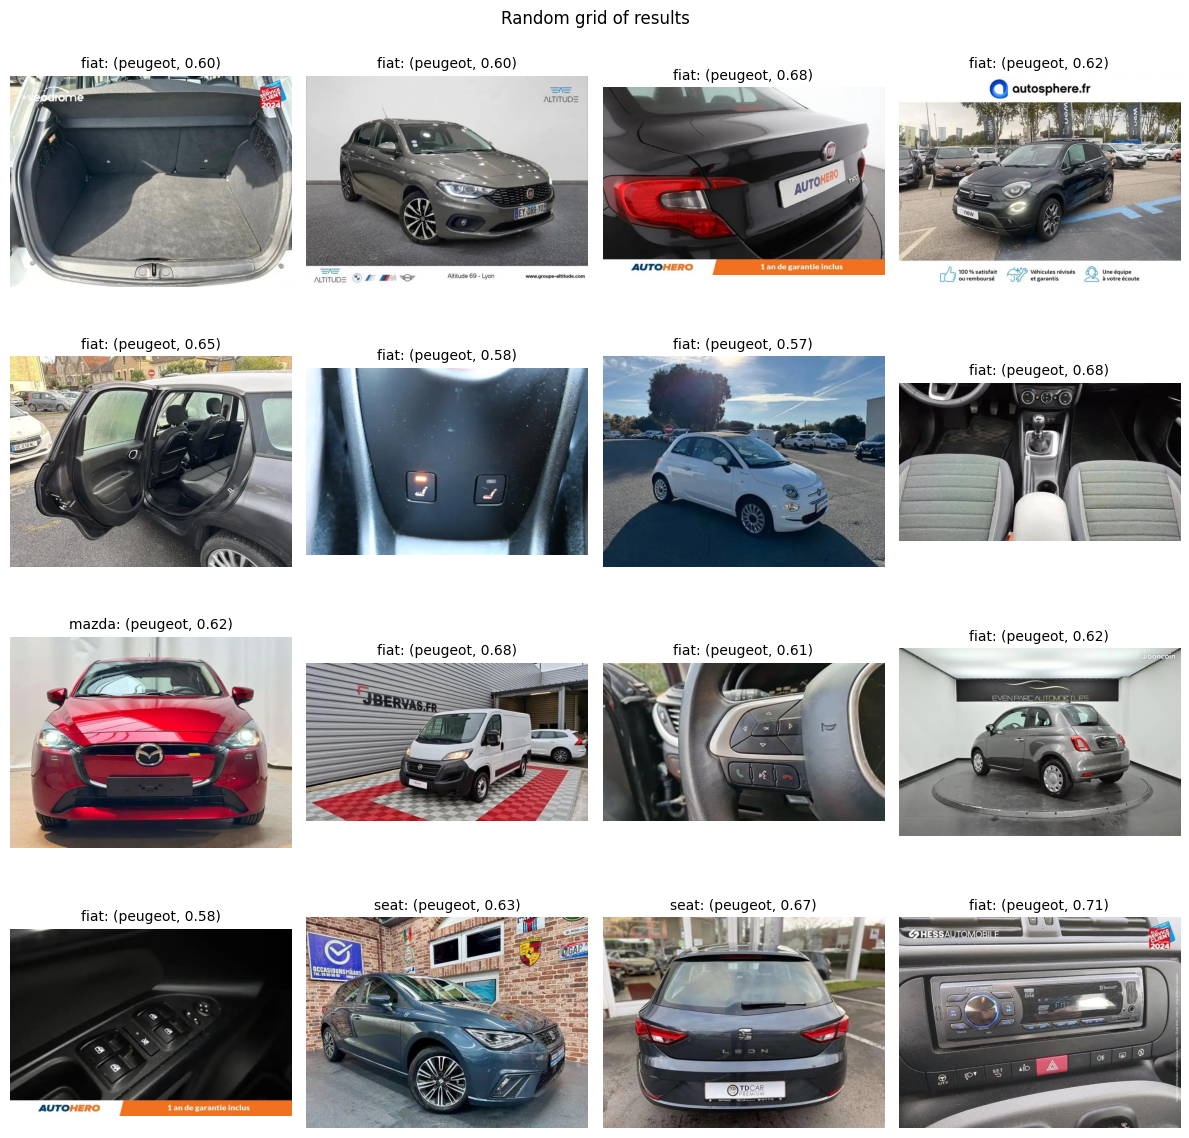

In [51]:
x,y= [4,4]
fig, axes = plt.subplots(x, y, figsize=(12, 12))
axes = axes.flatten()

for i, (index, row) in enumerate(results.sample(x*y).iterrows()):
    image_path = row['image_path']
    brand = row['brand']
    prediction = row['prediction']
    certainty = row['certainty']
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{brand}: ({prediction}, {certainty:.2f})", fontsize=10)
    axes[i].axis('off')
plt.suptitle('Random grid of results')
plt.tight_layout()
plt.show()

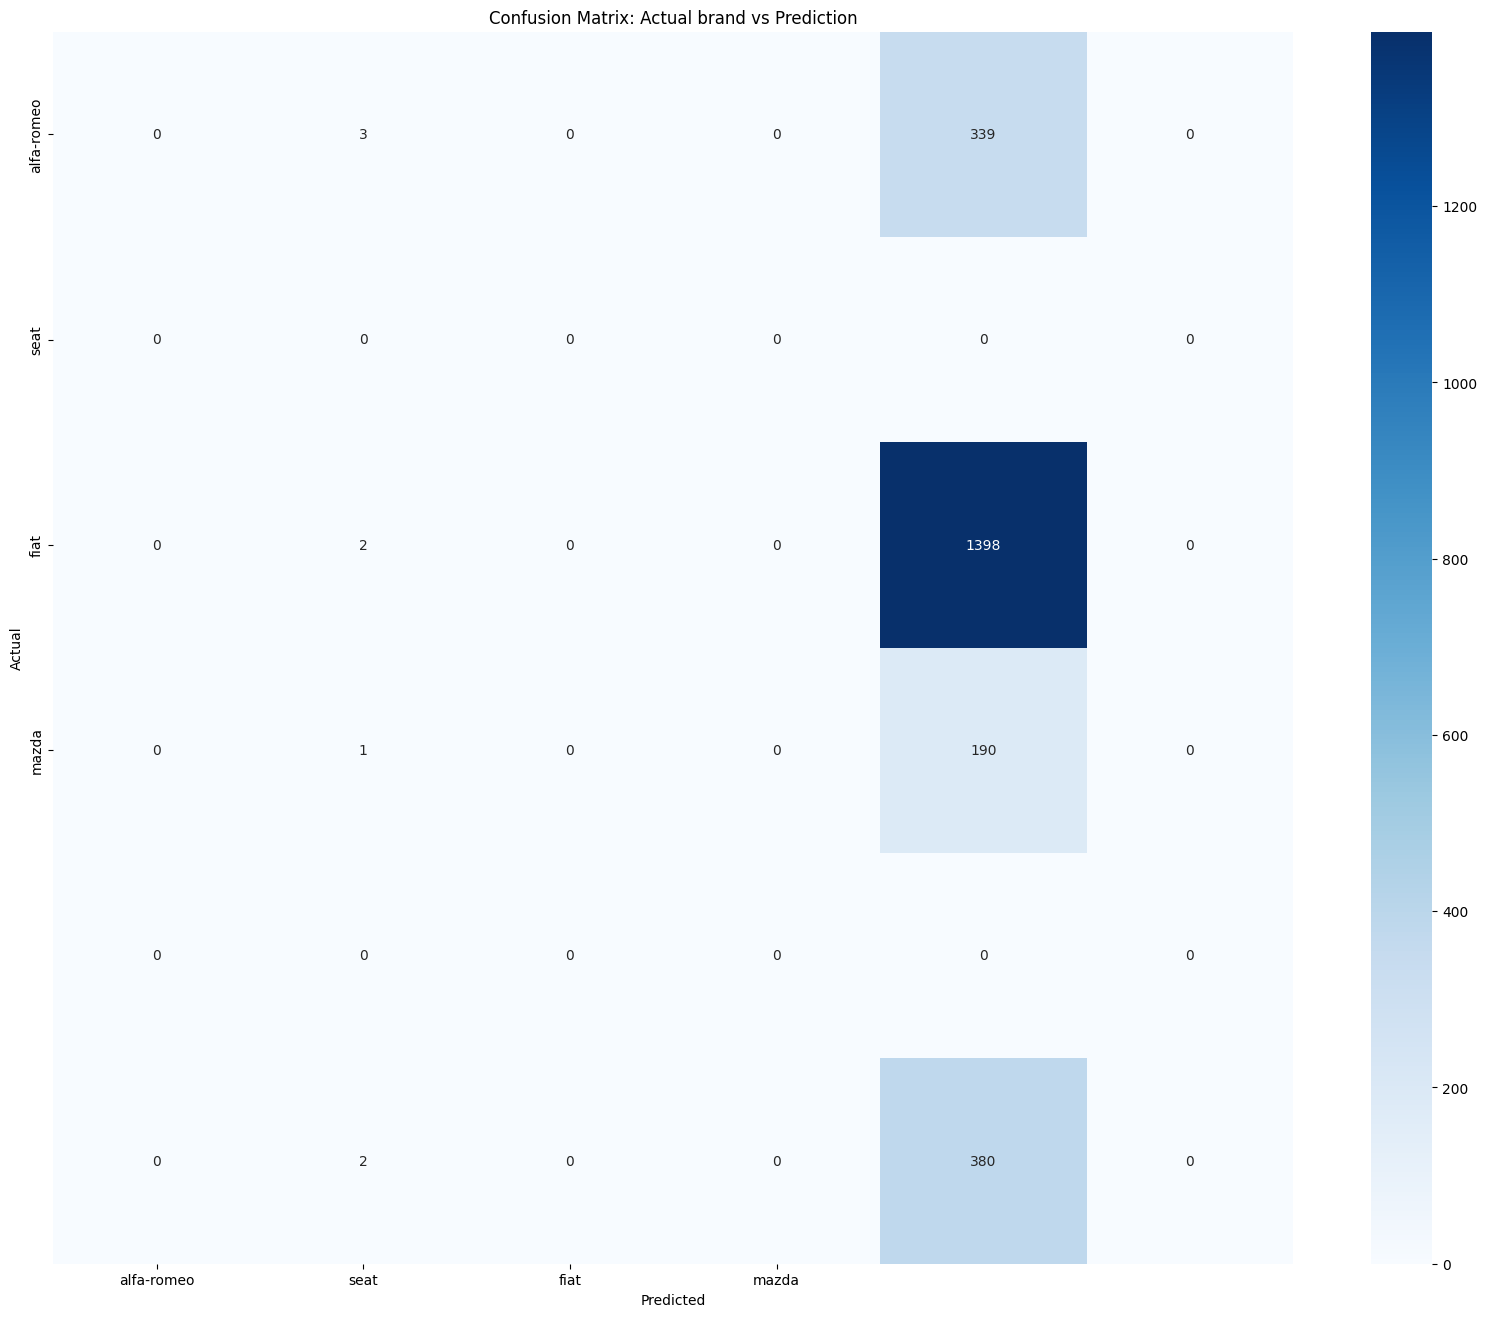

In [52]:
confusion = confusion_matrix(results['brand'], results['prediction'])
plt.figure(figsize=(20, 16))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=results['brand'].unique(), yticklabels=results['brand'].unique())
plt.title('Confusion Matrix: Actual brand vs Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ValueError: a must be greater than 0 unless no samples are taken

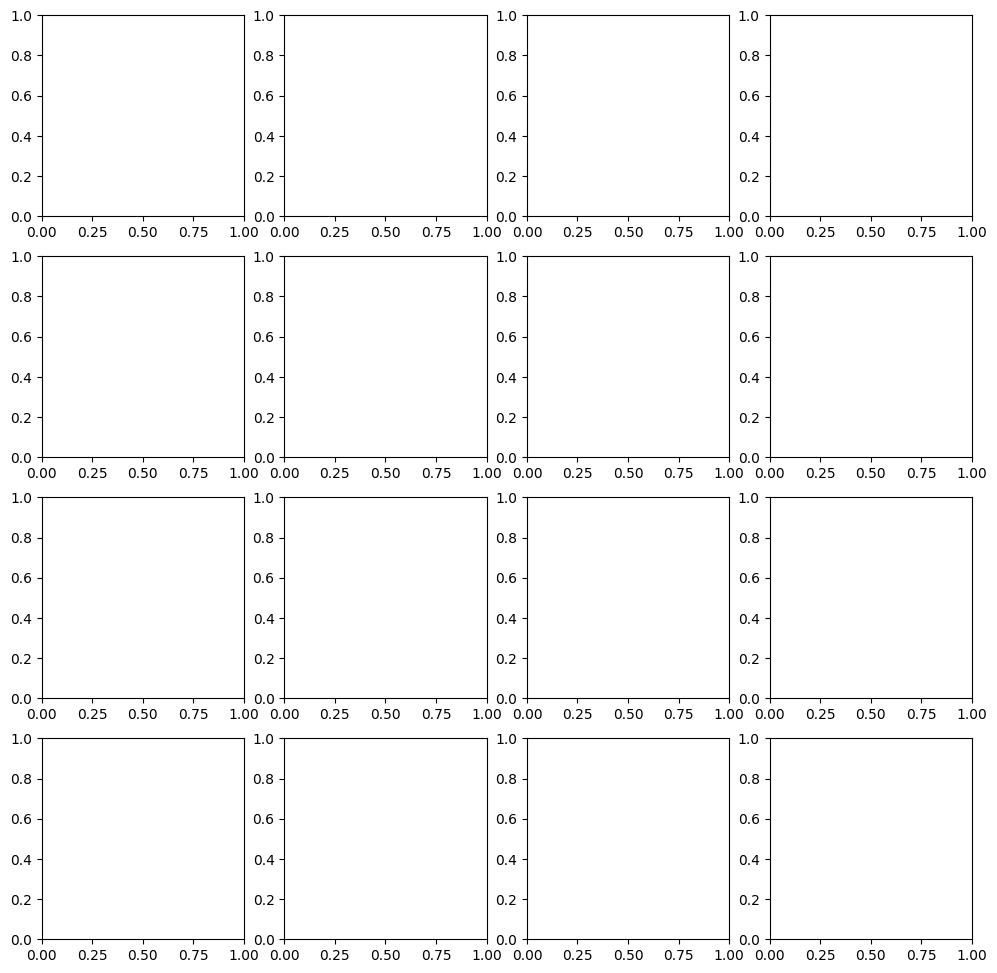

In [47]:
fig, axes = plt.subplots(x, y, figsize=(12, 12))
axes = axes.flatten()

for i, (index, row) in enumerate(results.loc[(results['brand'] == results['prediction']) & (results['certainty'] >= 0.9)].sample(x*y).iterrows()):
    image_path = row['image_path']
    brand = row['brand']
    prediction = row['prediction']
    certainty = row['certainty']
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{brand}: ({prediction}, {certainty:.2f})", fontsize=10)
    axes[i].axis('off')
plt.suptitle('Random grid of True results')
plt.tight_layout()
plt.show()

# Horrible results.

Question for you: WHY?
- Tip: What kind of preprocessing have I forgotten?